In [1]:
import level1,level2,analysis,plottools,inversions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import datetime as dt
import scipy.stats as stats
import numpy.ma as ma
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize as sciopt
import matplotlib.tri as tri
import scipy as sc

In [2]:
# Data
eddies = np.load('../../eddies_last.npy').item()
ADCPs = np.load('../../ADCPS.npy').item()

# Eddy model

## The Rankine vortex
In this work, we approximate the eddies by Rankine vortices defined by a core in solid body rotation (SBR) until a typical radius R where it reaches its maximum velocity V and then decays with $1/r$ :
$$
\tilde{v}(r) = \left\{
            \begin{array}{r l}
                \frac{Vr}{R} & \text{when } r \leq R \\
                \frac{VR}{r} & \text{when } r \gt R
            \end{array}
            \right.
$$

In [3]:
# Center coordinates
center = (0,0)
# Rankine parameters
cR = 50
mV = 0.5
par = (cR,mV)

### Cross section of a Rankine vortex going through the center

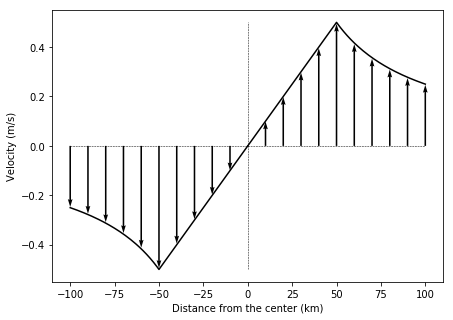

In [14]:
# Space
r = np.arange(-100,101,1)
r2 = np.arange(-100,110,10)
# Simulation
mv = inversions.Rankine(r,par)
mv2 = inversions.Rankine(r2,par)
# Figure
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
# Plot
ax.plot(r,mv,'k-')
ax.plot([-100,100],[0,0],'k--',linewidth=0.5)
ax.plot([0,0],[-0.5,0.5],'k--',linewidth=0.5)
Q = ax.quiver(r2,np.zeros(len(r2)),np.zeros(len(r2)),mv2,width=0.004,scale=1.6)
#ax.quiverkey(Q,0.8,0.1,0.5,label= '0.5 m/s')
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Distance from the center (km)')
#plt.savefig('cutrankine.pdf')
plt.show()

### 2D representation of a Rankine vortex

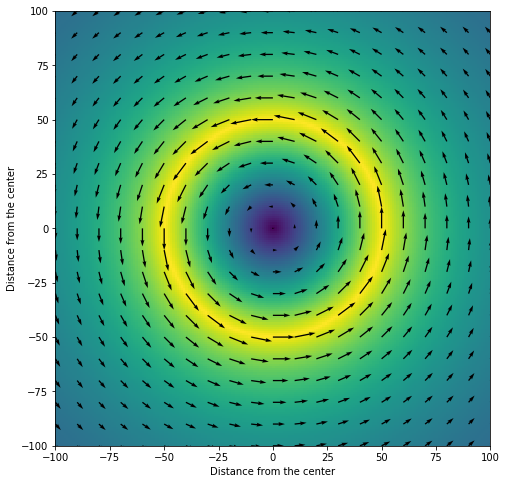

In [15]:
# Fine space
xx = np.arange(-100,101,1)
yy = np.arange(-100,101,1)
XX,YY = np.meshgrid(xx,yy)
# Coarse space
xx2 = np.arange(-100,110,10)
yy2 = np.arange(-100,110,10)
XX2,YY2 = np.meshgrid(xx2,yy2)
# Absolute velocities of fine space
angles,norms = inversions.SimulateRankine(center,par,XX,YY,fmt='AN')
# U and V on coarse space
rrU,rrV = inversions.SimulateRankine(center,par,XX2,YY2,fmt='UV')
# Figure setup
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1,1,1)
ax1.set_aspect('equal')
ax1.set_ylim(-100,100)
ax1.set_xlim(-100,100)
# Plots
ax1.pcolormesh(XX,YY,norms)
ax1.quiver(xx2,yy2,rrU,rrV,width=0.003,pivot='tail',scale=10)
ax1.set_ylabel('Distance from the center')
ax1.set_xlabel('Distance from the center')
#plt.savefig('rankineup.pdf')
plt.show()

# ADCP data analysis for eddy center detection

In [22]:
# Data import
eddy = 'M10'
U = eddies[eddy]['U']
V = eddies[eddy]['V']
U_filt = eddies[eddy]['U reg filt']
V_filt = eddies[eddy]['V reg filt']
atd = eddies[eddy]['ATD']
depths = eddies[eddy]['depths']
lon = eddies[eddy]['longitudes']
lat = eddies[eddy]['latitudes']
deltat = np.round(np.mean(ADCPs[eddy]['dates'][1:] - ADCPs[eddy]['dates'][:-1]).total_seconds(),0)

In [23]:
# Projection on mercator plane
m = Basemap(projection='merc',llcrnrlat = min(lat)-1,urcrnrlat = max(lat)+1,llcrnrlon=min(lon)-1,urcrnrlon=max(lon)+1)
x,y = m(lon,lat)

# Find the center

## Evaluate the solid body rotation component
Here, using a filter (accounting for all three dimensions of the problem), we evaluate the relevance of the solid body rotation assumption. Using an iterating algorithm, we map the correlation to SBR

In [5]:
faisceau,ZZ2,Rvals,Pvals=inversions.SolidBodyCorrelation(U_filt,V_filt,atd,depths,sizemax=200e3)
## Warning caused by nans but no computation errors

/usr/local/lib/python3.6/dist-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.6/dist-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


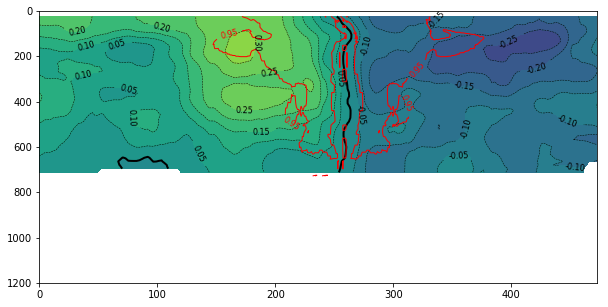

In [6]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(1200,0)
ax.set_xlim(min(atd)/1000,max(atd)/1000)
plottools.PlotADCP(ax,atd/1000,depths,V_filt)
levels = [0.95]
cont = ax.contour(faisceau/1000,ZZ2,Rvals,colors='r',linewidths=1,levels=levels)
ax.clabel(cont, fontsize=8, inline=1, fmt='%1.2f')
plt.show()

## Locate the center of the eddy

The strategy here is to simulate what the ship would have measured assuming it crossed a Rankine vortex centered in $(x_c,y_c)$. The distance between the simulation and measured data is minimized to obtain vortex center location and Rankine properties $(R,V)$.

A nice map of the error

In [209]:
xplore = np.arange(m.llcrnrx,m.urcrnrx,5e3)
yplore = np.arange(m.llcrnry,m.urcrnry,5e3)
Mrr = np.zeros((len(xplore),len(yplore)))
for i in range(len(xplore)):
    for j in range(len(yplore)):
        err = inversions.RankineErrorCenter([xplore[i],yplore[j],5e3,0.3],x,y,U_filt[:,30],V_filt[:,30])
        Mrr[i,j] = err

/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:3707: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:3716: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


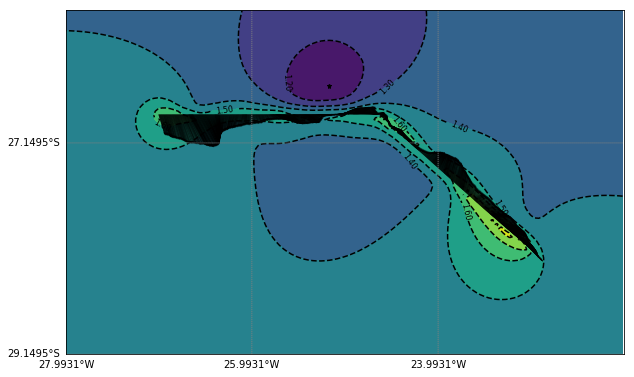

In [210]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
XX,YY = np.meshgrid(xplore,yplore)
M = np.transpose(Mrr)
plt.contourf(XX,YY,M)
cont = plt.contour(XX,YY,M,linestyles='dashed',colors='k')
ax.clabel(cont, fontsize=8, inline=1, fmt='%1.2f')
m.plot(XX[M==np.nanmin(M)],YY[M==np.nanmin(M)],'k*',ms=5)
m.quiver(x,y,U_filt[:,30],V_filt[:,30],pivot='tail',scale=2,width=0.001)
parallels = np.arange(m.llcrnrlat,m.urcrnrlat,2)
meridians = np.arange(m.llcrnrlon,m.urcrnrlon,2)
m.drawparallels(parallels,labels=[1,0,0,0],color='grey')
m.drawmeridians(meridians,labels=[0,0,0,1],color='grey')
plt.show()

In [24]:
Xvc,Yvc = inversions.VirtualCenters(V_filt,x,y,depths,deltat=deltat)

In [25]:
Xc,Yc,rRs,rVs,Er,S = inversions.RankineCenters(U_filt,V_filt,x,y,Xvc,Yvc,depths)

In [26]:
xc,yc = m(RankineProperties['M10']['RankineCenterX'],RankineProperties['M10']['RankineCenterY'])

Simulate what we would have measured

In [7]:
rkU,rkV = inversions.SimulatedField(Xc,Yc,rRs,rVs,x,y)

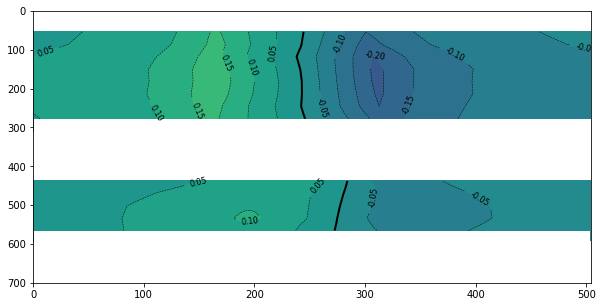

In [8]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
#X,Z = np.meshgrid(atd,depths)
ax.set_ylim(700,0)
#ax.contourf(X,Z,np.transpose(rkV))
plottools.PlotADCP(ax,atd/1000,depths,rkV)

Hodograph of the position of the center

In [10]:
Xcint = np.zeros(len(depths))
Ycint = np.zeros(len(depths))
Xcint[1:] = np.nancumsum(Xc[1:] - Xc[:-1])
Ycint[1:] = np.nancumsum(Yc[1:] - Yc[:-1])

In [100]:
## Now project everything on the cylinder

In [14]:
def ProjectEddyFrame(U,V,x,y,Xc,Yc):
    """
    Projects everything in the eddy frame
    """
    Ur = np.zeros(U.shape)
    Vr = np.zeros(V.shape)
    R = np.zeros(U.shape)
    R2 = np.zeros(U.shape)
    for i in range(U.shape[1]):
        xc = Xc[i]
        yc = Yc[i]
        if np.isfinite(xc):
            v = V[:,i]
            u = U[:,i]
            r = np.sqrt((x-xc)**2 + (y - yc)**2)
            s = np.sign(x-xc)
            s[s == 0] = 1
            r2 = s*np.sqrt((x-xc)**2 + (y - yc)**2)
            angles = np.angle((x - xc) + (y - yc)*1j,deg=False)
            num = np.isfinite(u)
            for j in range(len(angles)):
                if num[j]:
                    theta = angles[j]
                    uri,vri = level2.Rotation([u[j]],[v[j]],theta,[0,0])
                else:
                    uri = np.nan
                    vri = np.nan
                Ur[j,i] = s[j]*uri
                Vr[j,i] = s[j]*vri
        else:
            Ur[:,i] = np.full(len(angles),np.nan)
            Vr[:,i] = np.full(len(angles),np.nan)
        R[:,i] = r
        R2[:,i] = r2
    return(Ur,Vr,R,R2)

In [39]:
Ur,Vr,R,R2 = ProjectEddyFrame(U,V,x,y,xc,yc)

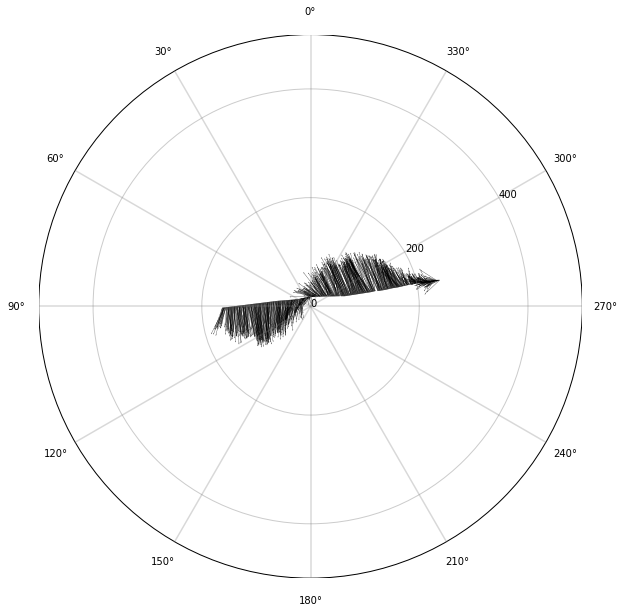

In [42]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1)
angles = np.angle((x - np.nanmean(xc[depths<150])) + (y - np.nanmean(yc[depths<150]))*1j,deg=False)
plottools.Hodograph(ax,500,xtext=False,ytext=False,grid=200)
ax.quiver(np.nanmean(R[:,depths<150],axis=1)/1000*np.cos(angles),np.nanmean(R[:,depths<150],axis=1)/1000*np.sin(angles),
          np.nanmean(U[:,depths<150],axis=1),np.nanmean(V[:,depths<150],axis=1),
          scale=5,width=0.0005)
plt.show()

In [17]:
RR = np.arange(-350e3,350e3,1e3)
idx = depths < 1200
VR = np.full((len(RR),len(depths[idx])),np.nan)

for i in range(len(depths[idx])):
    Vreg,Rreg = analysis.RegularLine(R2[:,i],Vr[:,i],5e3)
    Rreg = np.append(Rreg,0)
    Vreg = np.append(Vreg,0)
    sortidx = np.argsort(Rreg)
    Rreg = Rreg[sortidx]
    Vreg = Vreg[sortidx]
    mnspan = Rreg[0]
    mxspan = Rreg[-1]
    wheretointerp = (RR > mnspan)*(RR < mxspan)
    if np.sum(np.isfinite(Vreg))/len(Vreg) > 0.8:
        f = sc.interpolate.interp1d(Rreg[np.isfinite(Vreg)],Vreg[np.isfinite(Vreg)],assume_sorted=False,kind='slinear')
        VR[wheretointerp,i] = f(RR[wheretointerp])
        VR[~wheretointerp,i] = np.nan
    else:
        VR[:,i] = np.full(len(RR),np.nan)


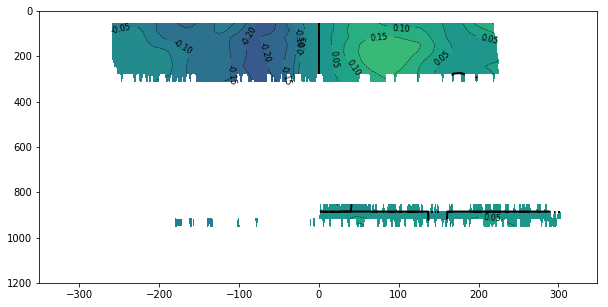

In [18]:
X,Z = np.meshgrid(RR,depths[idx])
#plt.ylim(700,0)
#plt.contourf(X,Z,np.transpose(VR))
#plt.contour(X,Z,np.transpose(VR),levels=[0],colors='k')
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(1200,0)
levels = np.round(np.arange(-0.6,0.65,.05),2)
levels2 = np.delete(levels,np.where(levels==0))
plottools.PlotADCP(ax,RR/1000,depths[idx],VR,levels=levels,levels2=levels2)

In [19]:
Zeta = 2 * np.gradient(VR,1e3,axis=0)

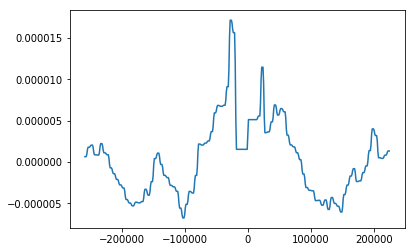

In [20]:
plt.plot(RR,Zeta[:,5])

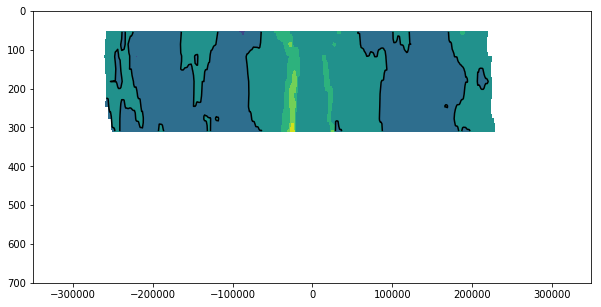

In [21]:
X,Z = np.meshgrid(RR,depths[idx])
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(700,0)
ax.contourf(X,Z,np.transpose(Zeta))
ax.contour(X,Z,np.transpose(Zeta),levels=[0],colors='k')

In [229]:
edkeys = list(eddies.keys())
RankineProperties = {}
for edkey in edkeys:
    U = eddies[edkey]['U']
    V = eddies[edkey]['V']
    U_filt = eddies[edkey]['U reg filt']
    V_filt = eddies[edkey]['V reg filt']
    atd = eddies[edkey]['ATD']
    depths = eddies[edkey]['depths']
    lon = eddies[edkey]['longitudes']
    lat = eddies[edkey]['latitudes']
    deltat = np.round(np.mean(ADCPs[edkey]['dates'][1:] - ADCPs[edkey]['dates'][:-1]).total_seconds(),0)
    m = Basemap(projection='merc',llcrnrlat = min(lat)-1,urcrnrlat = max(lat)+1,llcrnrlon=min(lon)-1,urcrnrlon=max(lon)+1)
    x,y = m(lon,lat)
    Xvc,Yvc = inversions.VirtualCenters(V_filt,x,y,depths,deltat=deltat)
    Xc,Yc,rRs,rVs,Er,S = inversions.RankineCenters(U_filt,V_filt,x,y,Xvc,Yvc,depths)
    omegas = np.arctan(rVs/rRs)
    xc,yc = m(Xc,Yc,inverse=True)
    xvc,yvc = m(Xvc,Yvc,inverse=True)
    rkU,rkV = inversions.SimulatedField(Xc,Yc,rRs,rVs,x,y)
    RankineProperties[edkey] = {'VirtCenterX':xvc,'VirtCenterY':yvc,
                                'RankineCenterX':xc,'RankineCenterY':yc,
                                'RankineR':rRs,'RankineV':rVs,'Omegas':omegas,
                                'ResError':Er,'Success':S,
                                'SimU':rkU,'SimV':rkV}

In [3]:
#np.save('../RankineProperties',RankineProperties)
RankineProperties = np.load('../RankineProperties.npy').item()

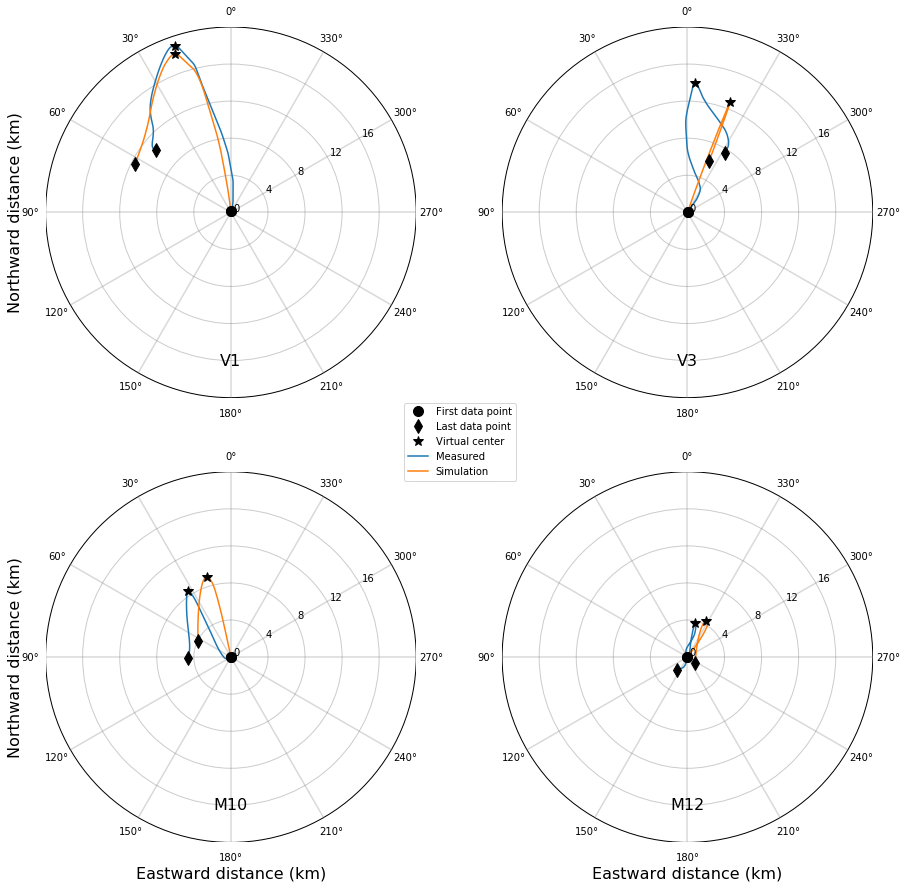

In [25]:
fig = plt.figure(figsize=(15,15))
edkeys = list(ADCPs.keys())
xtext = [False,False,True,True]
ytext = [True,False,True,False]
legend = [False,False,False,False]
for i in range(len(edkeys)):
    edkey = edkeys[i]
    ADCP = ADCPs[edkey]
    U = np.nanmean(eddies[edkeys[i]]['U reg filt'][:,ADCP['depths']<350],axis=1)
    V = np.nanmean(eddies[edkeys[i]]['V reg filt'][:,ADCP['depths']<350],axis=1)
    rkU = np.nanmean(RankineProperties[edkeys[i]]['SimU'][:,ADCP['depths']<350],axis=1)
    rkV = np.nanmean(RankineProperties[edkeys[i]]['SimV'][:,ADCP['depths']<350],axis=1)
    deltat = np.round(np.mean(ADCP['dates'][1:] - ADCP['dates'][:-1]).total_seconds(),0)
    ax = fig.add_subplot(2,2,i+1)
    xlim = 20
    plottools.Hodograph(ax,xlim,xtext=xtext[i],ytext=ytext[i],grid=4)
    plottools.PlotHodograph(ax,U,V,deltat,legend=legend[i])
    plottools.PlotHodograph(ax,rkU,rkV,deltat,legend=False)
    ax.text(0,-xlim+4,edkeys[i],fontsize=16,horizontalalignment='center',verticalalignment='center')
h,l=ax.get_legend_handles_labels()
l = l[:3]
h = h[:3]
blue_line = mlines.Line2D([], [], color='#1f77b4',markersize=15)
orange_line = mlines.Line2D([],[],color='#ff7f0e',markersize=15)
h = h + [blue_line,orange_line]
l = l + ['Measured','Simulation']
ax.legend(handles=h,labels=l,bbox_to_anchor=(0.05,1.2))

#plt.savefig('hodographs_simul.pdf')
plt.show()

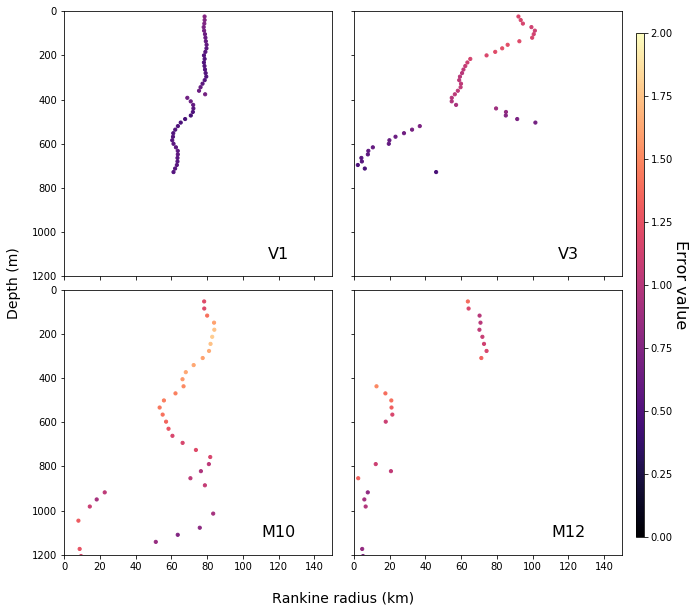

In [26]:
fig = plt.figure(figsize=(10,10))
edkeys = list(ADCPs.keys())
bigax = fig.add_subplot(1,1,1)
bigax.spines['top'].set_color('none')
bigax.spines['bottom'].set_color('none')
bigax.spines['left'].set_color('none')
bigax.spines['right'].set_color('none')
bigax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
for i in range(len(edkeys)):
    edkey = edkeys[i]
    rankprop = RankineProperties[edkey]
    depths = ADCPs[edkey]['depths']
    ax = fig.add_subplot(2,2,i+1)
    sc = ax.scatter(rankprop['RankineR']/1000,depths,c=rankprop['ResError'],s=10,vmin=0,vmax=2,cmap='magma')
    ax.set_ylim(1200,0)
    ax.set_xlim(0,150)
    ax.text(120,1100,edkey,fontsize=16,horizontalalignment='center',verticalalignment='center')
    if ~(i+1)%2:
        ax.yaxis.set_ticklabels([])
    if i < 2:
        ax.xaxis.set_ticklabels([])
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
cbar = plt.colorbar(sc,cax=cbar_ax)
cbar.set_label('Error value',rotation=270,fontsize=16,labelpad=15)
plt.subplots_adjust(wspace=0.08, hspace=0.05)
bigax.set_xlabel('Rankine radius (km)',fontsize=14,labelpad=20)
bigax.set_ylabel('Depth (m)',fontsize=14,labelpad=20)
#plt.savefig('RankineR.pdf')
plt.show()

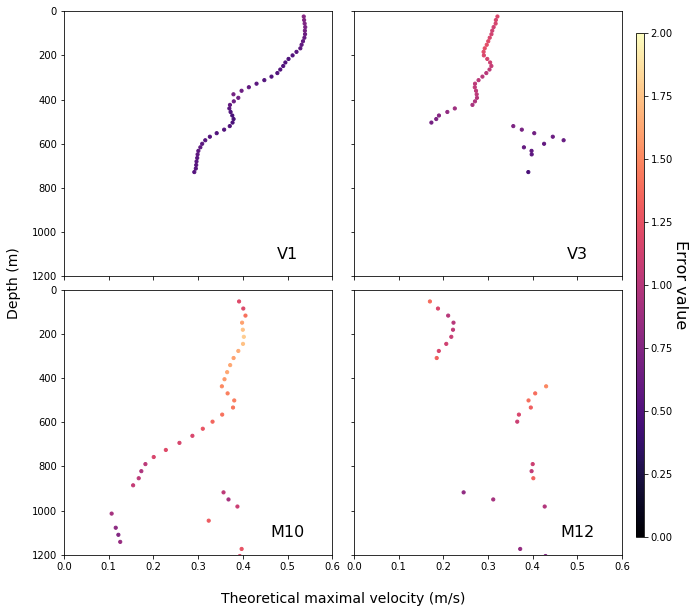

In [27]:
fig = plt.figure(figsize=(10,10))
edkeys = list(ADCPs.keys())
bigax = fig.add_subplot(1,1,1)
bigax.spines['top'].set_color('none')
bigax.spines['bottom'].set_color('none')
bigax.spines['left'].set_color('none')
bigax.spines['right'].set_color('none')
bigax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
for i in range(len(edkeys)):
    edkey = edkeys[i]
    rankprop = RankineProperties[edkey]
    depths = ADCPs[edkey]['depths']
    ax = fig.add_subplot(2,2,i+1)
    sc = ax.scatter(rankprop['RankineV'],depths,c=rankprop['ResError'],s=10,vmin=0,vmax=2,cmap='magma')
    ax.set_ylim(1200,0)
    ax.set_xlim(0,0.6)
    ax.text(0.5,1100,edkey,fontsize=16,horizontalalignment='center',verticalalignment='center')
    if ~(i+1)%2:
        ax.yaxis.set_ticklabels([])
    if i < 2:
        ax.xaxis.set_ticklabels([])
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
cbar = plt.colorbar(sc,cax=cbar_ax)
cbar.set_label('Error value',rotation=270,fontsize=16,labelpad=15)
plt.subplots_adjust(wspace=0.08, hspace=0.05)
bigax.set_xlabel('Theoretical maximal velocity (m/s)',fontsize=14,labelpad=20)
bigax.set_ylabel('Depth (m)',fontsize=14,labelpad=20)
#plt.savefig('RankineV.pdf')
plt.show()

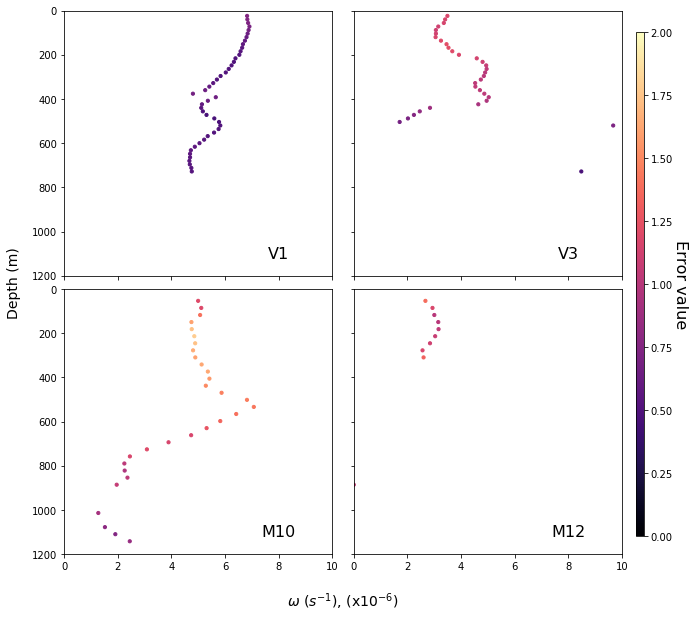

In [28]:
fig = plt.figure(figsize=(10,10))
edkeys = list(ADCPs.keys())
bigax = fig.add_subplot(1,1,1)
bigax.spines['top'].set_color('none')
bigax.spines['bottom'].set_color('none')
bigax.spines['left'].set_color('none')
bigax.spines['right'].set_color('none')
bigax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
for i in range(len(edkeys)):
    edkey = edkeys[i]
    rankprop = RankineProperties[edkey]
    depths = ADCPs[edkey]['depths']
    ax = fig.add_subplot(2,2,i+1)
    sc = ax.scatter(rankprop['Omegas']*1e6,depths,c=rankprop['ResError'],s=10,vmin=0,vmax=2,cmap='magma')
    ax.set_ylim(1200,0)
    ax.set_xlim(0,10)
    ax.text(8,1100,edkey,fontsize=16,horizontalalignment='center',verticalalignment='center')
    if ~(i+1)%2:
        ax.yaxis.set_ticklabels([])
    if i < 2:
        ax.xaxis.set_ticklabels([])
    else:
        ax.ticklabel_format(axis='x', style='sci') 
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
cbar = plt.colorbar(sc,cax=cbar_ax)
cbar.set_label('Error value',rotation=270,fontsize=16,labelpad=15)
plt.subplots_adjust(wspace=0.08, hspace=0.05)
bigax.set_xlabel('$\omega$ ($s^{-1}$), (x$10^{-6}$)',fontsize=14,labelpad=20)
bigax.set_ylabel('Depth (m)',fontsize=14,labelpad=20)
#plt.savefig('RankineOmega.pdf')
plt.show()

In [19]:
ProjectedADCPs = {}
for edkey in list(eddies.keys()):
    depths = eddies[edkey]['depths']
    U = eddies[edkey]['U reg filt']
    V = eddies[edkey]['V reg filt']
    lon = eddies[edkey]['longitudes']
    lat = eddies[edkey]['latitudes']
    m = Basemap(projection='merc',llcrnrlat = min(lat)-1,urcrnrlat = max(lat)+1,llcrnrlon=min(lon)-1,urcrnrlon=max(lon)+1)
    x,y = m(lon,lat)
    Xc = RankineProperties[edkey]['RankineCenterX']
    Yc = RankineProperties[edkey]['RankineCenterY']
    xc,yc = m(Xc,Yc)
    Ur,Vr,R,R2 = ProjectEddyFrame(U,V,x,y,yc,xc)
    ProjectedADCPs[edkey] = {'Ur':Ur,'Vr':Vr,'R':R,'R2':R2}

ValueError: array must not contain infs or NaNs

In [21]:
edkeys[i]

'M10'

In [4]:
np.save('ProjectedADCPS',ProjectedADCPs)
#ProjectedADCPs = np.load('ProjectedADCPS.npy').item()

KeyError: 'M10'

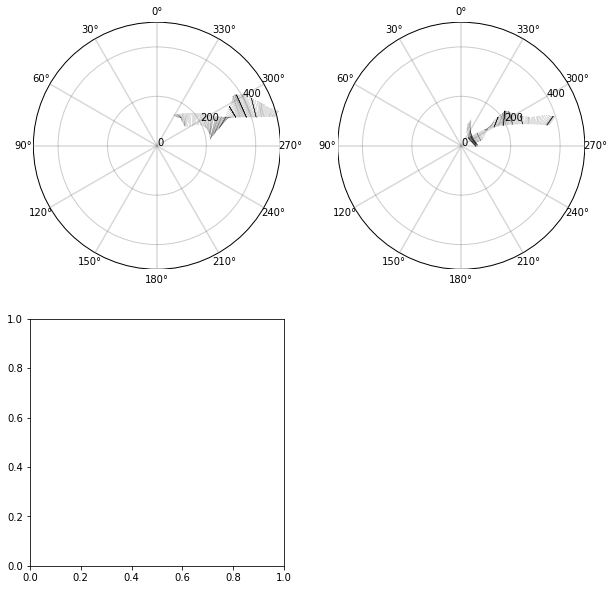

In [17]:
edkeys = list(eddies.keys())
fig = plt.figure(figsize = (10,10))
for i in range(len(edkeys)):
    ax = fig.add_subplot(2,2,i+1)
    edkey = edkeys[i]
    depths = eddies[edkey]['depths']
    Xc = RankineProperties[edkey]['RankineCenterX']
    Yc = RankineProperties[edkey]['RankineCenterY']
    U = eddies[edkey]['U reg filt']
    V = eddies[edkey]['V reg filt']
    R = ProjectedADCPs[edkey]['R']
    lon = eddies[edkey]['longitudes']
    lat = eddies[edkey]['latitudes']
    m = Basemap(projection='merc',llcrnrlat = min(lat)-1,urcrnrlat = max(lat)+1,llcrnrlon=min(lon)-1,urcrnrlon=max(lon)+1)
    x,y = m(lon,lat)
    xc,yc = m(Xc,Yc)
    angles = np.angle((x - np.nanmean(Xc[depths<150])) + (y - np.nanmean(Yc[depths<150]))*1j,deg=False)
    plottools.Hodograph(ax,500,xtext=False,ytext=False,grid=200)
    ax.quiver(np.nanmean(R[:,depths<150],axis=1)/1000*np.cos(angles),np.nanmean(R[:,depths<150],axis=1)/1000*np.sin(angles),
              np.nanmean(U[:,depths<150],axis=1),np.nanmean(V[:,depths<150],axis=1),
              scale=5,width=0.0005)
plt.show()